# Project #1. Bicycle model. PID controller

The project is related to modeling vehicle kinematics. Simple Bicycle model is used to model conventional vehicle motion.

Assumptions:
- flat world assumption
- no slip in contact points - i.e. no drifting
- use L = 2.65 meters. This is correct distance for our Nissan XTrail test vehicle
 
## The flow of the project:
- Implement classes **PID, Trajectory, BicycleModel, Robot, Experiment**. Some blank classes are down below in cells for reference.
- Implement PID controller tuning procedure - the Twiddle Algorythm. Good video with insight on Twiddle Algo is here https://www.youtube.com/watch?v=2uQ2BSzDvXs. Use class Experiment to automate experiment runs.
- Run tuning procedure and obtain resulting coeffs for PID controller
- Make a test run with tuned controller but on new trajectory
- Plot graphs and animations
- Write small report


## Graphs to plot:
- Plot animation of how Twiddle Algorythm tunes PID coeffs
- Plot Steering vs Time graph to visualize steering commands for each experiment
- Plot CTE vs Path length (NOT the time) graph to visualize cross track error along the trajectory


## Write little report. Give answers on the following questions:
- Try several different trajectories. Are they all sutable for PID tuning?
- How many iterations does is take for Twiddle to converge?
- Try to disturb initial position of a vehicle. How model behaives?
- What further improvements can be done on model and on PID tuning procedure?



## My contacts
- Email: Panchenko@cognitive.ru
- Telegram: +7-903-270-78-29




In [10]:
from math import tan, sin, cos
import math
import numpy as np
import shapely.geometry as geom
import matplotlib.pyplot as plt
from datetime import datetime
import os

%matplotlib notebook
from ipywidgets import *

In [2]:
# More info on PID controller you can find here:
# https://en.wikipedia.org/wiki/PID_controller
class PID:    
    def __init__(self, kp, ki, kd, dt):
        self.control = 0
        self.kp = kp
        self.ki = ki 
        self.kd = kd
        self.dt = dt
        
        self.cte_old = 0
        self.cte_sum = 0
    
    def update(self, CTE):
        self.control = self.kp * CTE + self.ki * self.cte_sum + self.kd * (CTE - self.cte_old) / self.dt
        
        self.cte_old = CTE
        self.cte_sum += CTE * self.dt
        return self.control

In [3]:
class Trajectory:
    def __init__(self, points):
        self.coords = points
        self.line = geom.LineString(points)
        pass
        
    def getDistanceFromPoint(self, point):
        CTE = 0 # CTE - Cross Track Error - distance from give point to neares point on a curve
        CTE = self.line.distance(point)
        
        fr = self.line.project(point)
        p_before = self.line.interpolate(fr - 0.1)
        p_after = self.line.interpolate(fr + 0.1)
        r = geom.LinearRing(geom.LineString([p_before, point, p_after]))
        if not r.is_ccw:
            CTE *= -1
        return CTE

In [4]:
class BicycleModel:
    def __init__(self, x, y, theta, L):
        self.x = x
        self.y = y
        self.theta = theta
        self.L = L
    
    def Move(self, steering, speed, dt):
        if math.fabs(steering) < 0.01:
            self.x = self.x + speed * dt * cos(self.theta)
            self.y = self.y + speed * dt * sin(self.theta)
            return
        
        steering = max(-70, min(70, steering))
        steering *= (math.pi / 180)
        R = self.L / tan(steering)
        beta = speed * dt / R
        self.x = self.x - R * sin(self.theta) + R * sin(self.theta + beta)
        self.y = self.y + R * cos(self.theta) - R * cos(self.theta + beta)
        self.theta += beta
        
    def getPosition(self):
        return geom.Point(self.x, self.y)

In [5]:
class Robot:
    def __init__(self, bicycleModel, pidController, speed, ax, animate_step=False):
        self.model = bicycleModel
        self.pid = pidController
        self.speed = speed
        self.ax = ax
        self.steering = [0]
        if ax is not None:
            self.t_line, = self.ax.plot([i for i in range(len(self.steering))], self.steering,
                         color='green', marker=',', scalex=False, scaley=False)
        self.animate_step = animate_step
    
    def followPath(self, trajectory, dt):
        CTE = trajectory.getDistanceFromPoint(self.model.getPosition())
        steering = self.pid.update(CTE)
        self.model.Move(steering, self.speed, dt)
        self.steering.append(steering)
        if self.animate_step:
            self.draw_steering()
    
    def getPosition(self):
        return self.model.getPosition()
    
    def draw_steering(self):
        # TODO: draw robot steering vs. time plot in separate window
        self.t_line.set_xdata([i for i in range(len(self.steering))])
        self.t_line.set_ydata(self.steering)
        # recompute the ax.dataLim
        self.ax.relim()
        # update ax.viewLim using the new dataLim
        self.ax.autoscale_view()     


In [82]:
class Experiment:
    def __init__(self, robot, trajectory, axd, fig, animate_step=False):
        self.robot = robot
        self.trajectory = trajectory
        self.fig = fig 
        self.animate_step = animate_step
        
        self.pos = [self.robot.getPosition()]
        if axd.get('Trajectory') is not None:
            self.ax_traj = axd['Trajectory']
            self.ax_traj.plot([c.x for c in trajectory.coords], [c.y for c in trajectory.coords],
                         color='blue', marker='o', scalex=False, scaley=False, label='Trajectory')
            self.t_line, = self.ax_traj.plot([p.x for p in self.pos], [p.y for p in self.pos],
                         color='red', marker='.', scalex=False, scaley=False, label='Robot')
            self.ax_traj.axis('equal')
            self.ax_traj.legend()
        
        self.cte_len = [(0,0)]
        if axd.get('CTE') is not None:
            self.ax_cte = axd['CTE']
            self.cl_line, = self.ax_cte.plot([x for x,y in self.cte_len], [y for x,y in self.cte_len],
                         color='red', marker=',', scalex=False, scaley=False)
            self.ax_cte.axis('equal')
        
        
    def run(self, dt, max_iterations, err_weight = 0.9):
        score = 0
        weighted_score = 0
        for i in range(max_iterations):
            self.robot.followPath(self.trajectory, dt)
            cur_score = self.trajectory.getDistanceFromPoint(self.robot.getPosition())
            score += math.fabs(cur_score)
#           смотрим на нектоторую длину вперёд
            weighted_score += math.fabs(cur_score) * err_weight**i
            self.pos.append(self.robot.getPosition())
            self.cte_len.append((geom.LineString(self.pos).length, cur_score))
            if self.animate_step:
                self.draw_trajectory()
                self.draw_cte()
                self.fig.canvas.draw()
        return score, weighted_score
    
    def draw_trajectory(self):
        # draw animation window with robot model and trajectory
        self.t_line.set_xdata([p.x for p in self.pos])
        self.t_line.set_ydata([p.y for p in self.pos])
        self.ax_traj.relim()
        self.ax_traj.autoscale_view()
        
    def draw_cte(self):
        # draw animation window with robot cte
        self.cl_line.set_xdata([x for x,y in self.cte_len])
        self.cl_line.set_ydata([y for x,y in self.cte_len])
        self.ax_cte.relim()
        self.ax_cte.autoscale_view()


# Tests

### Рисуем и сохраняем несколько траекторий

In [19]:
input_coords = []
class UserDraw(object):
    def __init__(self, ax):
        self.ax = ax
        ax.figure.canvas.mpl_connect('button_press_event', self)
   
    def __call__(self, event):
        x, y = event.xdata, event.ydata
        point = geom.Point(x, y)
        input_coords.append(point)
        self.update_curve(point)
        
    def update_curve(self, point):
        self.ax.plot([c.x for c in input_coords], [c.y for c in input_coords],
                     color='blue', marker='o', scalex=False, scaley=False)
        fig.canvas.draw()

<IPython.core.display.Javascript object>


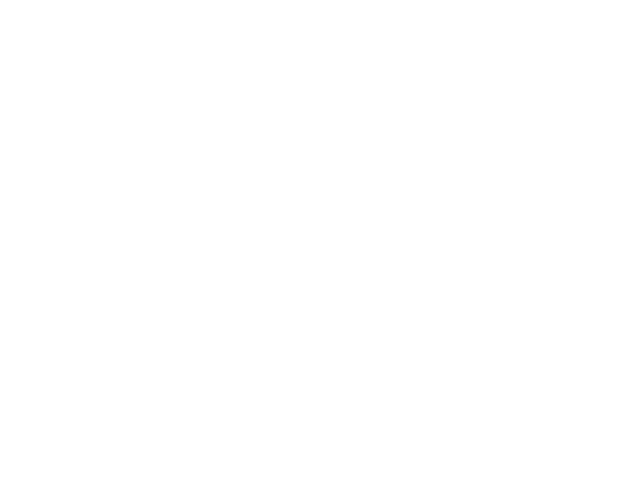

In [20]:
fig, ax = plt.subplots()
ax.set_ylim([-5,40])
ax.set_xlim([-5,40])
UserDraw(ax)
plt.show()

In [21]:
now = datetime.now().strftime("%b-%d_%H:%M:%S")  # create unique names

c_to_save = []
for c in input_coords:
    c_to_save.append((c.x, c.y))
np.savetxt("graph{}.txt".format(now), np.array(c_to_save))

### PID tuning code

In [114]:
#put PID tuning code in this cell

def set_graphs(title):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0,0].set_title('Trajectory')
    axs[0,0].set_xlabel('метры')
    axs[0,0].set_ylabel('тут тоже метры')
    
    axs[0,1].set_title('Twiddle')
    axs[0,1].set_xlabel('iteration')
    axs[0,1].set_ylabel('value')
    
    axs[1,0].set_title('Steering')
    axs[1,0].set_xlabel('time step')
    axs[1,0].set_ylabel('steering')
    
    axs[1,1].set_title('CTE VS path length')
    axs[1,1].set_ylabel('CTE')
    axs[1,1].set_xlabel('path length')
    
    fig.tight_layout()
    fig.suptitle(title, fontsize=16, y=1)
    
    axd = {'Trajectory': axs[0,0], 'Twiddle': axs[0,1], 'Steering': axs[1,0], 'CTE': axs[1,1]}
    return fig, axd

def clear_graph_data(ax):
    if ax is not None:
        for artist in ax.lines + ax.collections:
            artist.remove()


def set_experiment(pid_params, coords,
                   speed = 5,
                   L = 2.65,
                   dt = 0.1,
                   max_iterations = 100,
                   theta = None,
                   start_pos=None,
                   animate_step=False,
                   axd = None, fig = None):
    
    if axd == None or fig == None:
        print("no plot data")
        return
    clear_graph_data(axd['Trajectory'])
    clear_graph_data(axd['Steering'])
    clear_graph_data(axd['CTE'])
    
    if start_pos == None:
        start_pos = coords[0]
    if theta == None:
        a = (1,0)
        b = (coords[1].x - coords[0].x, coords[1].y - coords[0].y)
        product = b[0]
        theta = math.acos(product / math.sqrt(b[0]**2 + b[1]**2))      
    model = BicycleModel(start_pos.x, start_pos.y, theta, L)
    robot = Robot(model, PID(pid_params[0], pid_params[1], pid_params[2], dt), speed, axd['Steering'], animate_step=animate_step)
    return Experiment(robot, Trajectory(coords), axd, fig, animate_step=animate_step)

def tune_pid(pid_params,
             coords, 
             tolerance = 0.5,
             speed = 5,
             L = 2.65,
             dt = 0.1,
             max_iterations = 100,
             err_weight = 0.9,
             theta = None,
             start_pos=None,
             axd = None, fig = None):
    p = pid_params
    pid_log = [(p[0],p[1],p[2])]
    dp = [1,1,1]
    best_err = 9999999
    ax = axd['Twiddle']
    clear_graph_data(axd['Twiddle'])
    kp_line, = ax.plot([c for c,_,_ in pid_log], [i for i in range(len(pid_log))],
                     color='#ff4242', marker=',', scalex=False, scaley=False, label='Kp')
    ki_line, = ax.plot([c for _,c,_ in pid_log], [i for i in range(len(pid_log))],
                     color='#42f9ff', marker=',', scalex=False, scaley=False, label='Ki')
    kd_line, = ax.plot([c for _,_,c in pid_log], [i for i in range(len(pid_log))],
                     color='#9dff42', marker=',', scalex=False, scaley=False, label='Kd')
#     ax.axis('equal')
    ax.legend()
    E = None
    last_sum_err = 9999999
    max_chances = 2
    while sum(dp) > tolerance:
        for i in range(3): 
            if i == 1 and err_weight != 1:
                continue
        
            p[i] += dp[i]
            E = set_experiment(pid_params, coords, speed=speed, L=L, dt=dt, max_iterations=max_iterations, theta=theta,
                              start_pos=start_pos, axd=axd, fig=fig, animate_step=False)
            sum_err, err = E.run(dt, max_iterations, err_weight=err_weight)
            
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2*dp[i]
                E = set_experiment(pid_params, coords, speed=speed, L=L, dt=dt, max_iterations=max_iterations, theta=theta,
                              start_pos=start_pos, axd=axd, fig=fig, animate_step=False)
                sum_err, w_err = E.run(dt, max_iterations, err_weight=err_weight)
#                 print("kp: {}\terr: {}".format(p[0],err))
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
                    
        pid_log.append((p[0],p[1],p[2]))
        kp_line.set_xdata([i for i in range(len(pid_log))])
        kp_line.set_ydata([x for x,y,z in pid_log])
        ki_line.set_xdata([i for i in range(len(pid_log))])
        ki_line.set_ydata([y for x,y,z in pid_log])
        kd_line.set_xdata([i for i in range(len(pid_log))])
        kd_line.set_ydata([z for x,y,z in pid_log])
        ax.relim()
        ax.autoscale_view()
        E.draw_trajectory()
        E.draw_cte()
        E.robot.draw_steering()

        fig.canvas.draw()
        
#       если по взвешенной сумме начали переобучаться, перестаём использовать веса (вернее, делаем все веса 1)
        if last_sum_err < sum_err and max_chances < 0:
            err_weight = 1
            best_err = last_sum_err
#             print("using full weight")
        elif last_sum_err < sum_err and max_chances >= 0:
            max_chances -= 1
        else:
            last_sum_err = sum_err
        
#         print(err, geom.LineString(E.pos).length)
#         print(sum_err, err, dp)
        
        
    print("PID: ({},{},{})\nerror: {}".format(p[0], p[1], p[2], err))
    return p

### Запускаем эксперименты

In [88]:
pid_results = {}

# for i in range(4):
def train_graph(gid, max_iterations=150, tolerance=0.5, err_weight = 0.9):
    t1 = datetime.now()  
    fig, axd = set_graphs("Training on graph_{}".format(gid))

    loaded = np.loadtxt("graph{}.txt".format(gid))
    coords = [geom.Point(p) for p in loaded]
    result = tune_pid([0,0,0], coords, err_weight=err_weight, fig=fig, axd=axd, tolerance = tolerance, max_iterations=max_iterations)
    
    t2 = datetime.now()
    print("time spent: {}".format(t2 - t1))
    return result
    
    

<IPython.core.display.Javascript object>


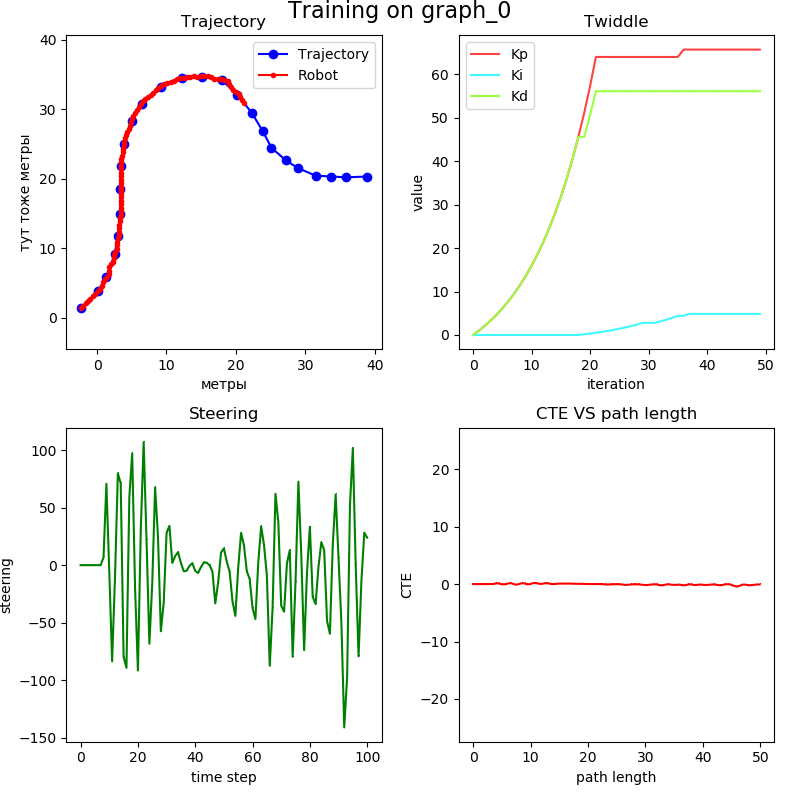

PID: (65.695439263478,4.848333769180655,56.1074168574227)
error: 10.629060458340694
time spent: 0:00:48.684720


In [115]:
pid_results[0] = train_graph(0, max_iterations = 100, tolerance=1, err_weight = 1)

<IPython.core.display.Javascript object>


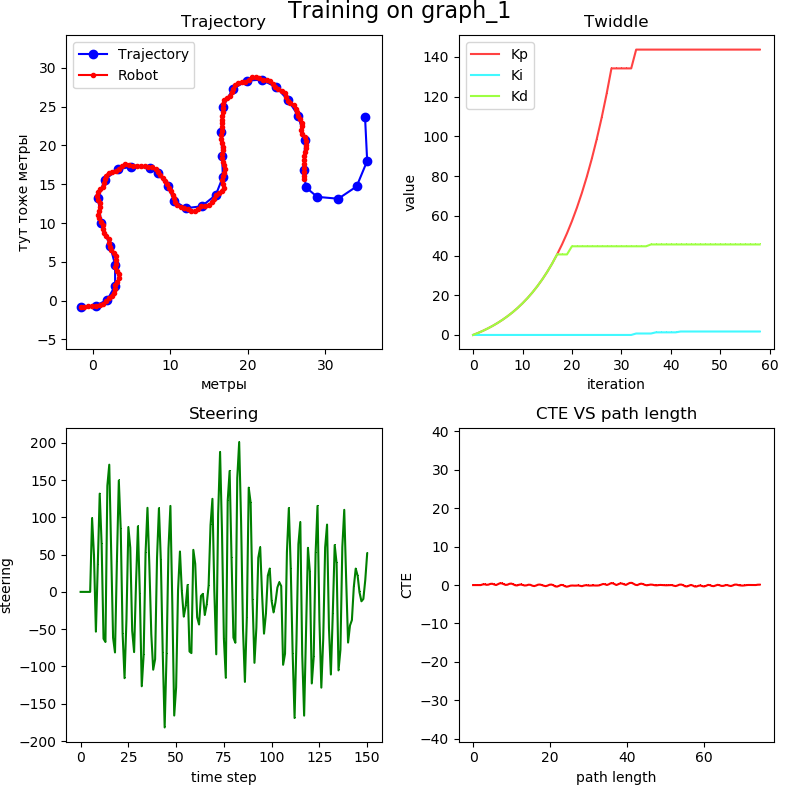

PID: (143.67155001444684,1.7354860125210017,45.56606129349606)
error: 24.20037046578483
time spent: 0:01:27.023713


In [116]:
pid_results[1] = train_graph(1, max_iterations = 150, tolerance=1, err_weight=0.85)

<IPython.core.display.Javascript object>


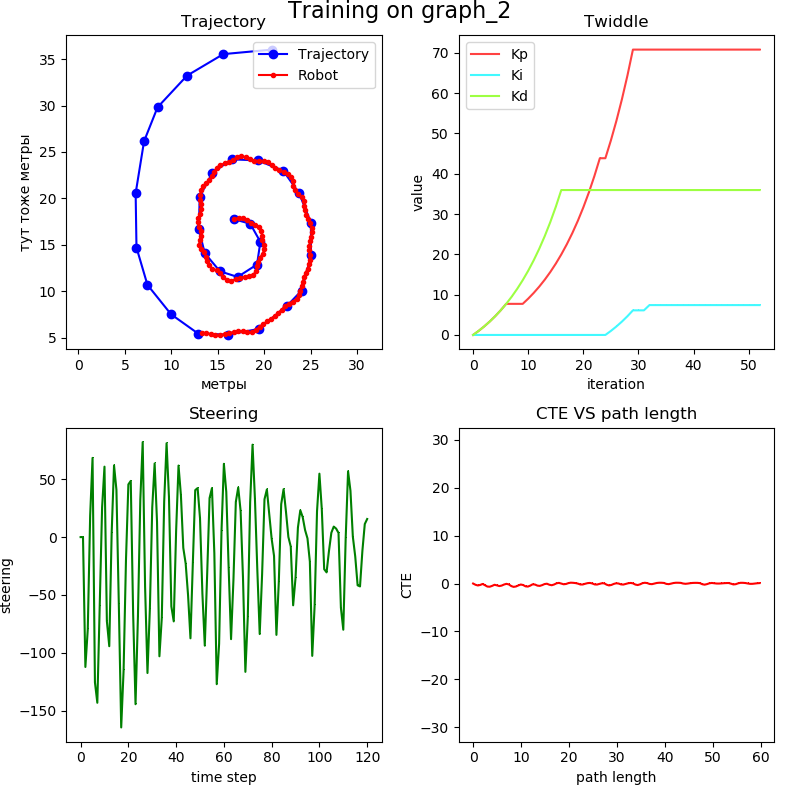

PID: (70.79178346762951,7.409613100000001,35.94972986357218)
error: 22.58699804090145
time spent: 0:00:55.379817


In [117]:
pid_results[2] = train_graph(2, max_iterations = 120, tolerance=1, err_weight=0.85)

<IPython.core.display.Javascript object>


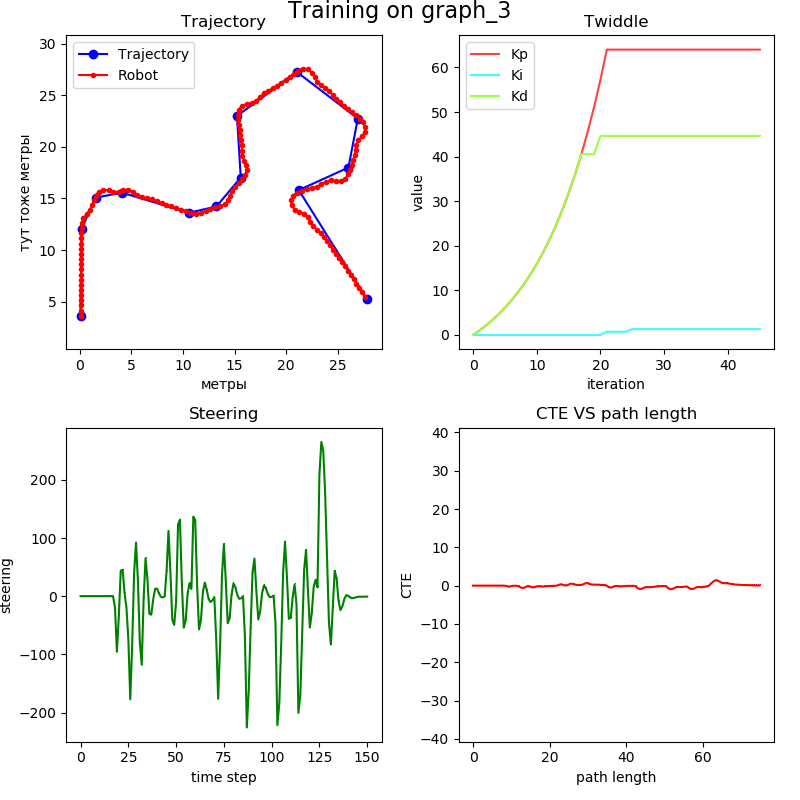

PID: (64.00249944258171,1.3135851000000007,44.63882378077375)
error: 41.496882821599115
time spent: 0:01:06.587212


In [118]:
pid_results[3] =  train_graph(3, max_iterations = 150, tolerance=1,  err_weight=0.85)

### Запустим на другой траектории

In [150]:
def run_on_all(pid_results, pid_id, max_iterations = 150, start_pos=None):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0,0].set_title('graph 0')
    axs[0,1].set_title('graph 1')
    axs[1,0].set_title('graph 2')
    axs[1,1].set_title('graph 3')
    fig.tight_layout()
    fig.suptitle("PID {}: [{:0.1f}, {:0.1f}, {:0.1f}]".format(pid_id,
                                                            pid_results[pid_id][0],
                                                            pid_results[pid_id][1],
                                                            pid_results[pid_id][2]), fontsize=16, y=1)
    
    axd = {'Trajectory': None, 'Twiddle': None, 'Steering': None, 'CTE': None}
    
    axd['Trajectory'] = axs[0,0]
    loaded = np.loadtxt("graph{}.txt".format(0))
    coords = [geom.Point(p) for p in loaded]
    E = set_experiment(pid_results[pid_id], coords, start_pos=start_pos, fig = fig, axd=axd)
    E.run(0.1, max_iterations)
    E.draw_trajectory()
    
    axd['Trajectory'] = axs[0,1]
    loaded = np.loadtxt("graph{}.txt".format(1))
    coords = [geom.Point(p) for p in loaded]
    E = set_experiment(pid_results[pid_id], coords, start_pos=start_pos, fig = fig, axd=axd)
    E.run(0.1, max_iterations)
    E.draw_trajectory()
    
    axd['Trajectory'] = axs[1,0]
    loaded = np.loadtxt("graph{}.txt".format(2))
    coords = [geom.Point(p) for p in loaded]
    E = set_experiment(pid_results[pid_id], coords, start_pos=start_pos, fig = fig, axd=axd)
    E.run(0.1, max_iterations)
    E.draw_trajectory()
    
    axd['Trajectory'] = axs[1,1]
    loaded = np.loadtxt("graph{}.txt".format(3))
    coords = [geom.Point(p) for p in loaded]
    E = set_experiment(pid_results[pid_id], coords, start_pos=start_pos, fig = fig, axd=axd)
    E.run(0.1, max_iterations)
    E.draw_trajectory()

    fig.canvas.draw()
    
    

<IPython.core.display.Javascript object>


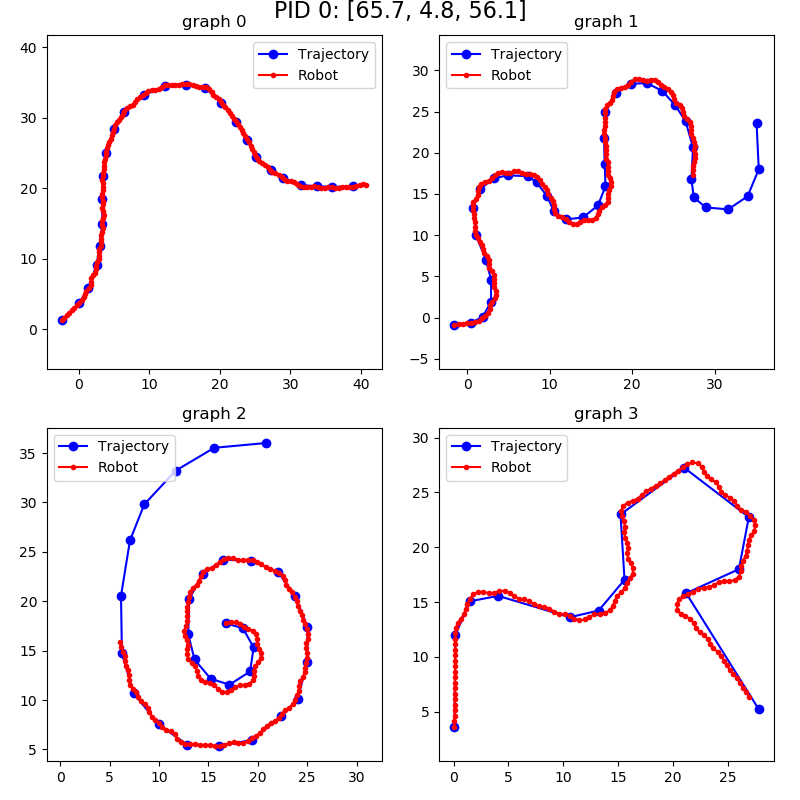

In [120]:
run_on_all(pid_results, 0)

<IPython.core.display.Javascript object>


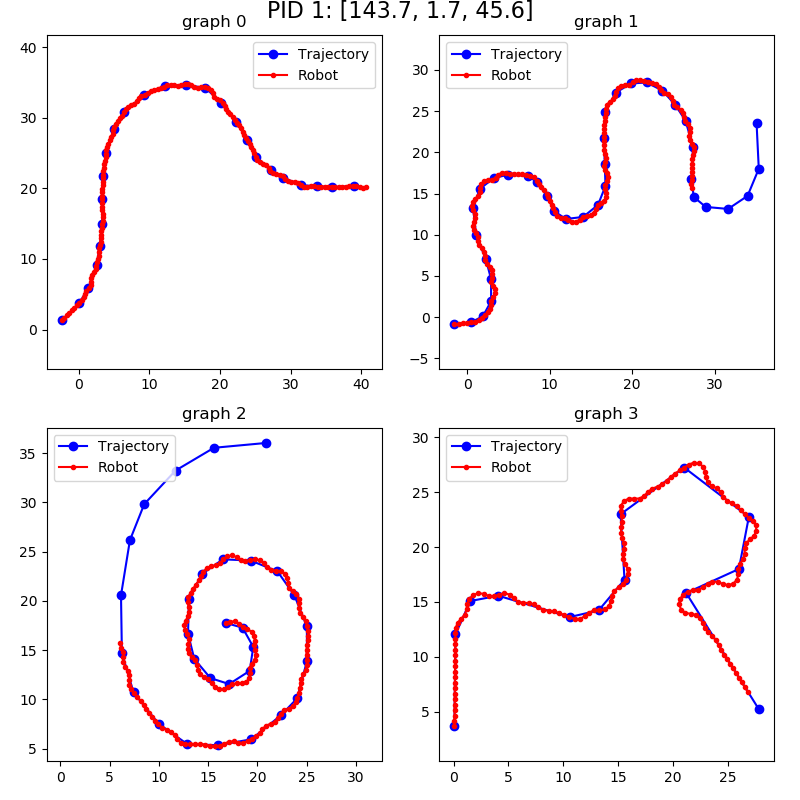

In [121]:
run_on_all(pid_results, 1)

<IPython.core.display.Javascript object>


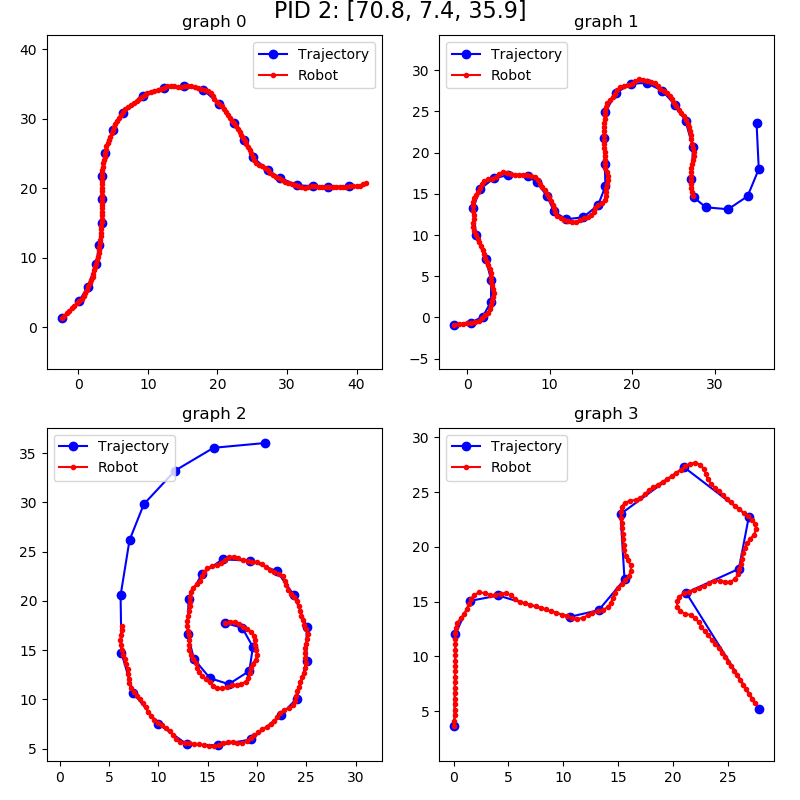

In [122]:
run_on_all(pid_results, 2)

<IPython.core.display.Javascript object>


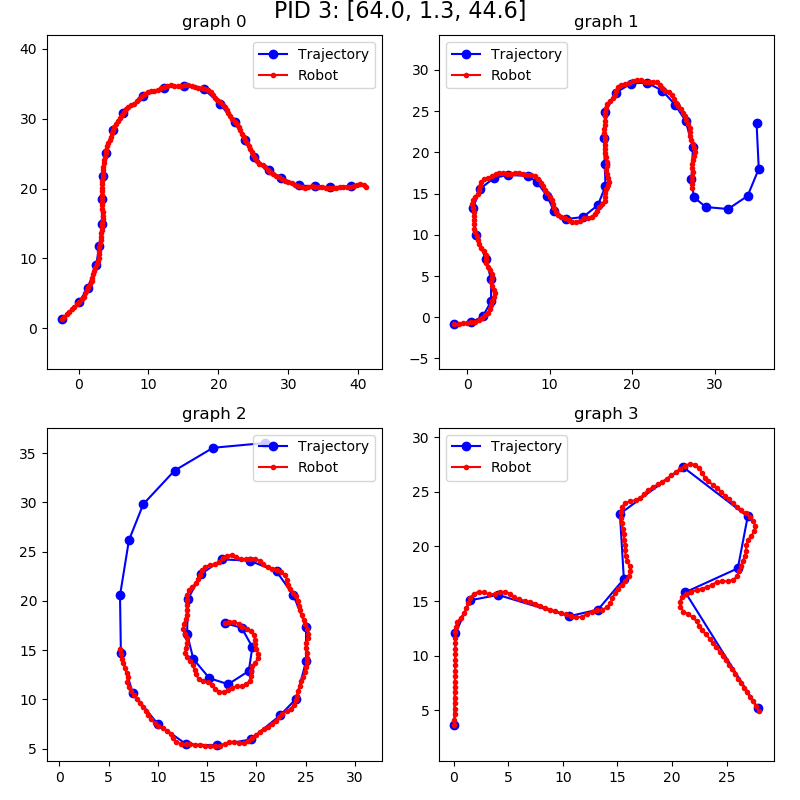

In [123]:
run_on_all(pid_results, 3)

## Тренируем со смещением начальной точки

In [124]:
# for i in range(4):
def train_graph(gid, max_iterations=150, tolerance=0.5,  err_weight=0.9):
    t1 = datetime.now()  
    fig, axd = set_graphs("Training on graph_{}".format(gid))
    

    loaded = np.loadtxt("graph{}.txt".format(gid))
    coords = [geom.Point(p) for p in loaded]
    start_pos = geom.Point(coords[0].x - 1, coords[0].y + 1)
    
    result = tune_pid([0,0,0], coords, fig=fig, axd=axd, tolerance = tolerance,
                      max_iterations=max_iterations, start_pos=start_pos,  err_weight=err_weight)

    t2 = datetime.now()
    print("time spent: {}".format(t2 - t1))
    return result
    
    

<IPython.core.display.Javascript object>


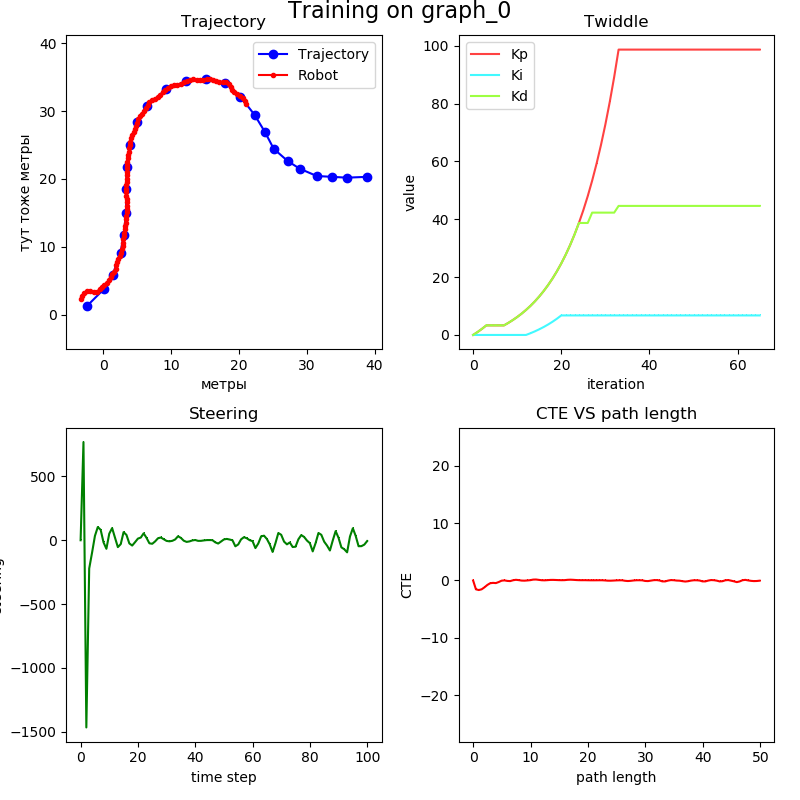

PID: (98.65506198742175,6.752777564169004,44.613982314317525)
error: 14.547091521251058
time spent: 0:01:03.596875


In [126]:
pid_results[0] = train_graph(0, max_iterations = 100, err_weight=0.85)

<IPython.core.display.Javascript object>


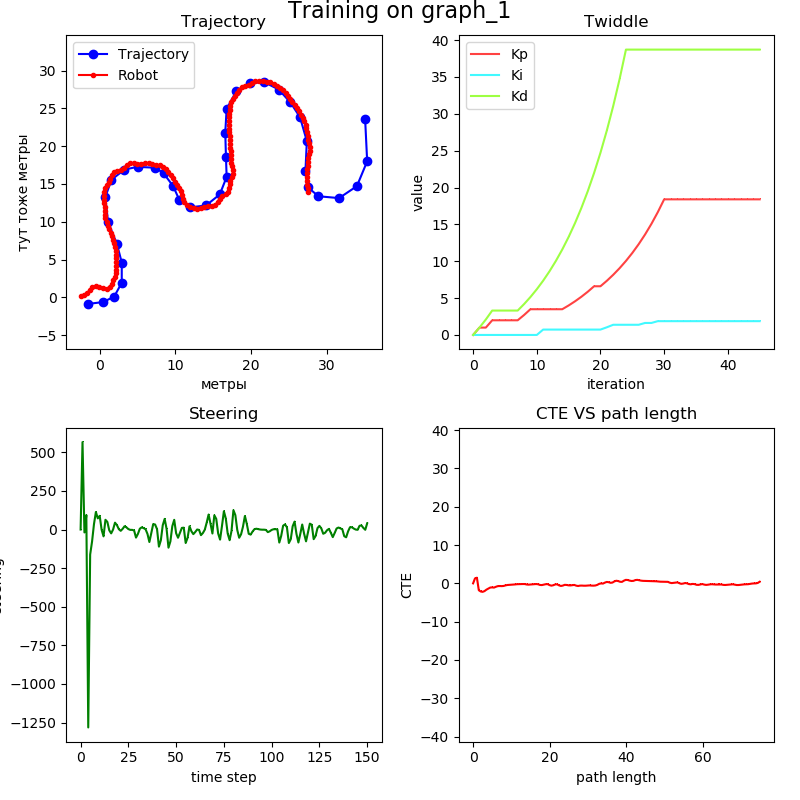

PID: (18.399970201170387,1.8722198336721076,38.7164361675253)
error: 69.70289700734565
time spent: 0:01:12.462323


In [133]:
pid_results[1] = train_graph(1, max_iterations = 150, tolerance=1,  err_weight=0.82)

<IPython.core.display.Javascript object>


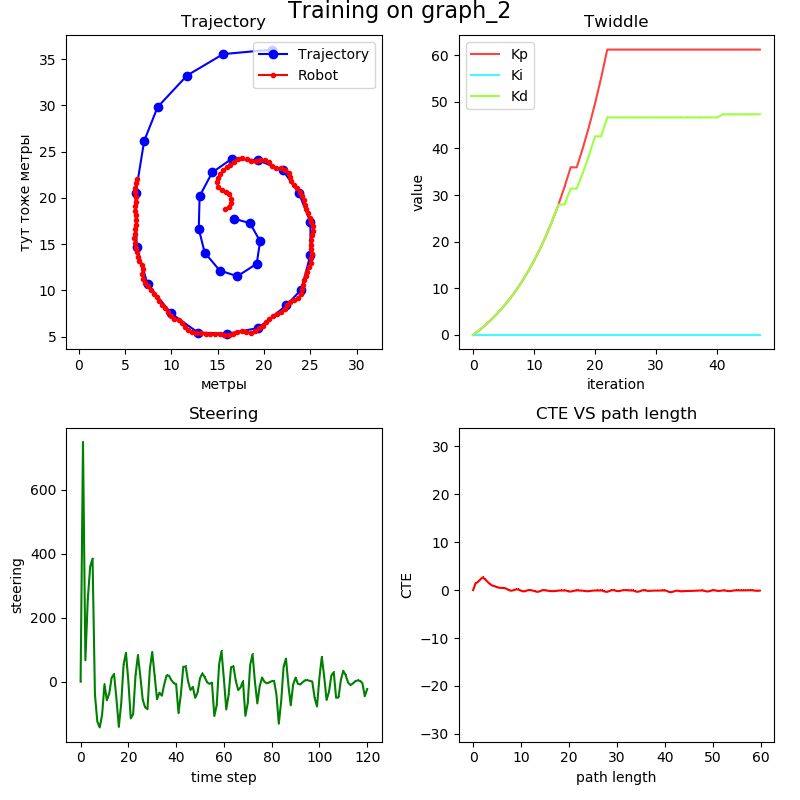

PID: (61.19722248468072,0.0,47.314728234436274)
error: 34.020608292357295
time spent: 0:00:48.156674


In [145]:
pid_results[2] = train_graph(2, max_iterations = 120, tolerance=1,  err_weight=0.95)

<IPython.core.display.Javascript object>


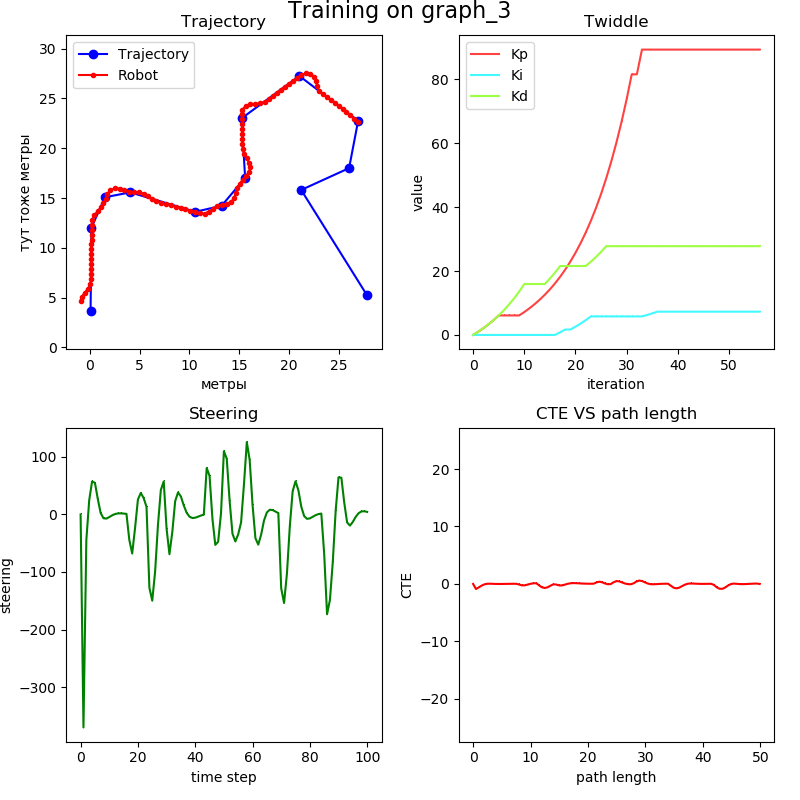

PID: (89.29453625056996,7.285295982039816,27.777479231988373)
error: 18.714425180727748
time spent: 0:00:49.684603


In [148]:
pid_results[3] =  train_graph(3, max_iterations = 100, tolerance=1,  err_weight=0.85)

## Запускаем на других траекториях

<IPython.core.display.Javascript object>


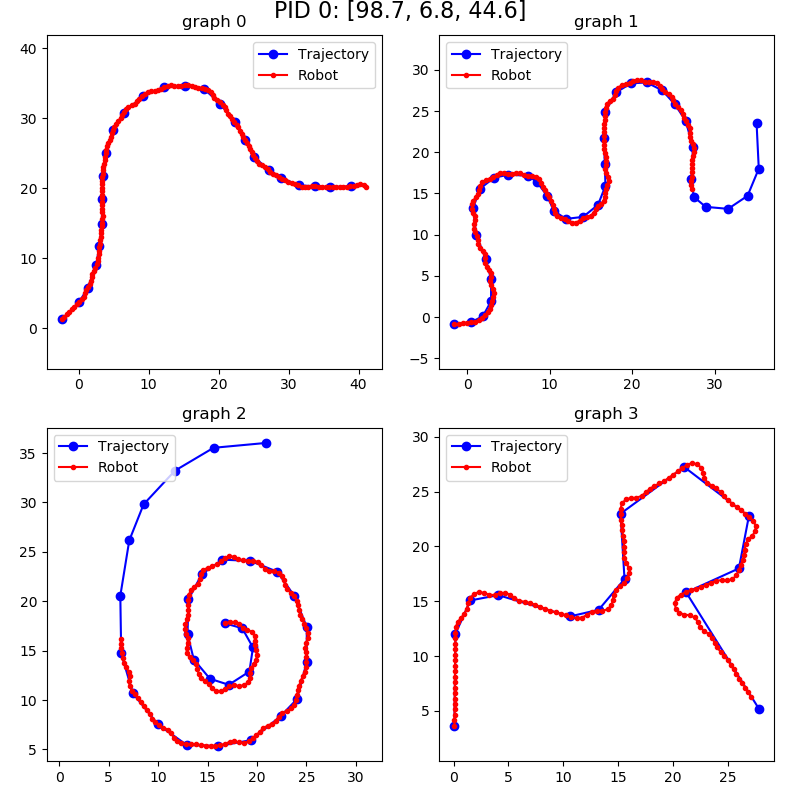

In [152]:
run_on_all(pid_results, 0)

<IPython.core.display.Javascript object>


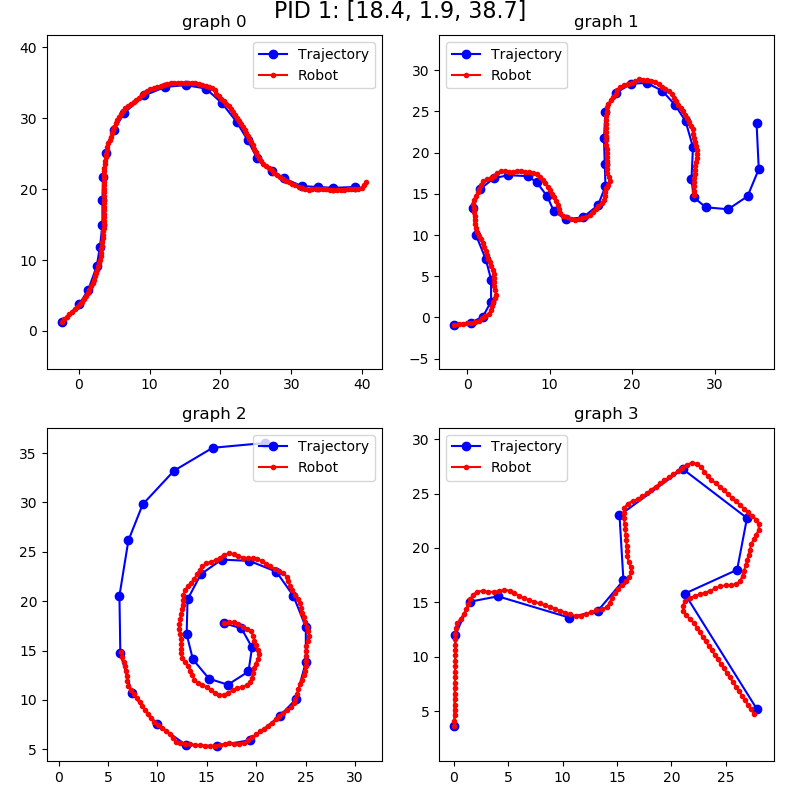

In [153]:
run_on_all(pid_results, 1)

<IPython.core.display.Javascript object>


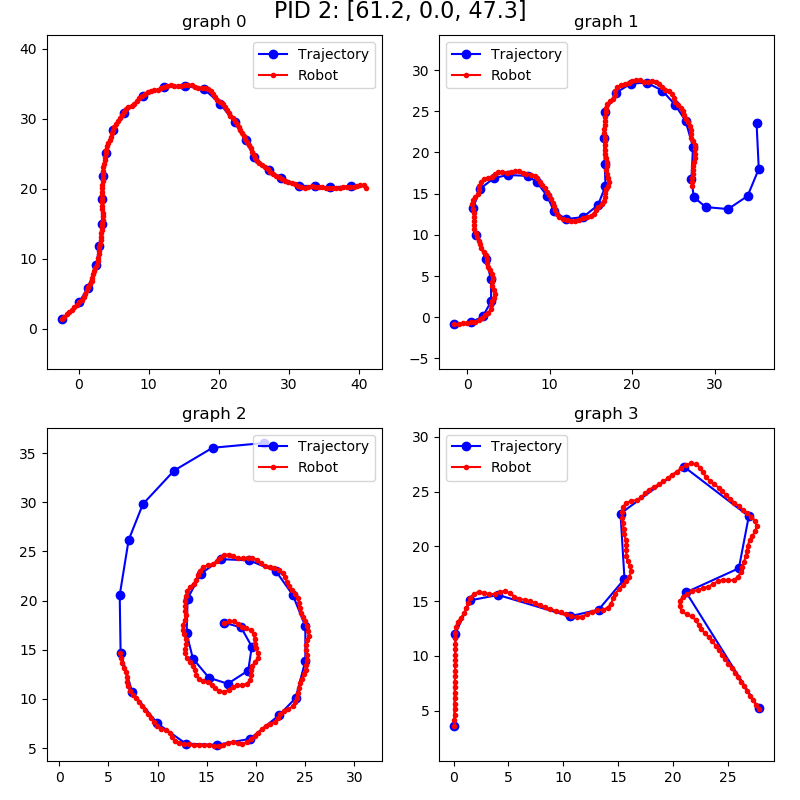

In [154]:
run_on_all(pid_results, 2)

<IPython.core.display.Javascript object>


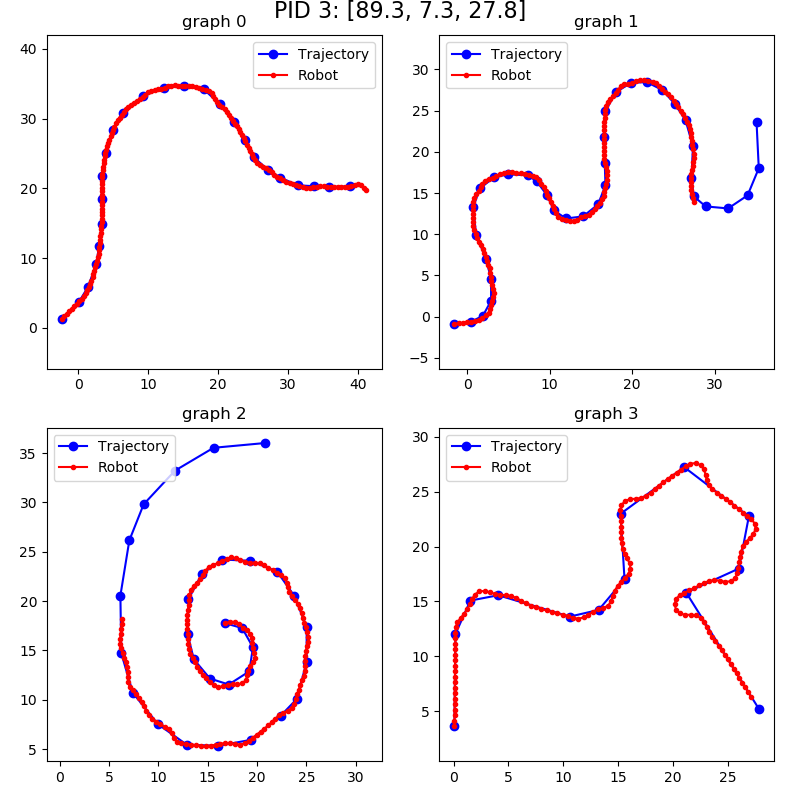

In [155]:
run_on_all(pid_results, 3)

## Project report:

Put your report here. Feel free to use pictures, graphs, animations.



**Try several different trajectories. Are they all sutable for PID tuning?**

Не на всех траекториях получается хорошо найти коэффициенты, резкие повороты в начале траектории сильно снижают сходимость, но если подобрать хорошую loss функцию, то можно заметно улучшить результат. (подробнее в последнем пункте)


**How many iterations does is take for Twiddle to converge?**

В основном 45-60 итераций.

**Try to disturb initial position of a vehicle. How model behaives?**

Если отклонение небольшое, то обычно это не сильно мешает и алгоритм всё равно сходится. Однако если при смещении стартовая точка оказалась на примерно одном расстоянии от двух точек траектории (например на изгибе), то модель может поехать не туда. Это видно на примере со спиральной траекторией.
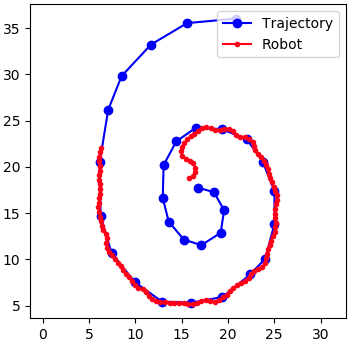


**What further improvements can be done on model and on PID tuning procedure?**

Я уже использовал несколько улучшений:

1) На некоторых траекториях алгоритм twiddle не находил приемлемых коэффициентов, так как я использовал суммарную ошибку на траектории. При таком способе если в траектории много поворотов, то алгоритм не увидит сильных изменений в ошибке при малых изменениях значений. Но алгоритм построен так, что не наблюдая улучшений значения dp начнут только падать и мы сойдёмся так и не найдя нормальных коэффициентов. Поэтому я решил использовать взвешенную сумму: на каждом шаге модель робота умножает ошибку на err_weight**(номер шага). Так как err_weight < 1, то ошибка на каждом следующем шаге даёт меньший вклад и алгоритм начинает подбирать пид коэффициенты так, чтобы он хорошо ехал в начале траектории. Но в какой-то момент мы начинаем переобучаться, то есть значения взвешенной суммарной ошибки продолжают уменьшаться, а значения просто суммарной ошибки наоборот, начинают снова расти. В этот момент я устанавливаю err_weight = 1, то есть теперь использую обычную суммарную ошибку. К этому моменту траектория модели уже более-менее похожа на искомую, и алгоритм уже просто приближает её к искомой, сокращая суммарную ошибку. 

2) Большой проблемой оказалось то, что при большой накопленной ошибке в первых итерациях интегральная составляющая пид регулятора начинала сильно расти. Это называется Integral windup и приводит к тому, что значения выходного сигнала с пид регулятора становятся очень большими. В данной модели максимальный угол поворота я ограничил +-70 градусов, но из-за раздутия интегральной составляющей регулятор начинал выдавать значения больше 90 (что вообще смысла не имеет) и они продолжали расти, заглушая вообще весь сигнал. В общем, как и советуют в википедии, в начале я подбираю только kp и kd коэффициенты, то есть тренирую PD-регулятор, а когда траектория уже более-менее устаканилась (в тот момент, когда я устанавливаю err_weight = 1), я начинаю подбирать и интегральный коэффициент.